In [67]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

import ml_insights as mli

In [75]:
df = pd.read_csv('hypers.csv', index_col=0)
# model64 : sparse fully connected
# model88 : brushstroke
# model55 : sparse conv
# model101 : multi-scale sparse conv

model_names = ['model64', 'model101', 'model88', 'model55', 'gan']
output_cols = [
    'out_objectness', 
    'out_count', 
    'out_max',
    'in_objectness', 
    'in_count', 
    'in_max'
]
input_cols = list(set(df.columns) - set(output_cols))

# I you want to study a specific type of model, put its name
# in the variable 'model_name'. it should be a str among the 
# list 'model_names', which is defined above. Otherwise, if
# you want to study all the type of models at the same, set 
#'model_name' to None.
model_name = 'model64'
if model_name:
    df = df[df['model_name'] == model_name]
    df = df.dropna(axis=0, subset=output_cols)
    df = df.dropna(axis=1)

In [74]:
df.sort_values(by='out_objectness').head()

,k,l2,lr,model_name,nbatch,ndf,ndfc,ngf,ngfc,niter,niter_decay,nz,scale,in_objectness,out_objectness,in_max,in_count,out_max,out_count
1269,3,0.000850,0.013849,gan,128,128,8,8,128,150,100,150,0.034305,1.000044,0.999990,0.002129,0,0.102970,0
1435,1,0.000000,0.000200,gan,128,8,32,256,16,300,100,100,0.100000,0.999999,0.999992,0.001295,0,0.108424,0
1444,3,0.000000,0.000200,gan,128,64,32,128,256,50,100,100,0.039442,1.000005,0.999994,0.005133,0,0.139053,0
1443,3,0.000000,0.000200,gan,128,16,32,64,64,150,100,70,0.062803,1.000005,0.999994,0.005133,0,0.139053,0
1267,2,0.031257,0.000200,gan,128,64,1024,128,16,50,100,20,0.022570,1.000005,0.999994,0.005133,0,0.139053,0


## Feature importances

In [59]:
data = df.dropna(subset=output_cols, axis=0)
# shuffling data
ind = np.arange(len(data))
np.random.shuffle(ind)
data = data.iloc[ind]
data.head()

,k,l2,lr,model_name,nbatch,ndf,ndfc,ngf,ngfc,niter,niter_decay,nz,scale,in_objectness,out_objectness,in_max,in_count,out_max,out_count
1436,2,0,0.000200,gan,128,128,256,128,32,50,100,200,0.086975,9.291954,8.723921,0.981120,0.940852,0.341081,0
1408,2,0,0.003854,gan,128,32,16,32,8,100,100,300,0.004431,1.000005,0.999994,0.005133,0.000000,0.139053,0
1371,3,0,0.000200,gan,128,8,128,256,256,150,100,20,0.068926,9.339192,8.878401,0.984101,0.950216,0.329063,0
1375,1,0,0.000200,gan,128,32,256,32,16,100,100,20,0.045349,9.390053,9.478664,0.985855,0.959632,0.334656,0
1310,2,0,0.000200,gan,128,8,1024,32,8,100,100,20,0.043288,9.324706,9.149733,0.982443,0.952520,0.327262,0


In [70]:
x = data.drop(output_cols, axis=1)
x = pd.get_dummies(x)
x = x.fillna(-1)
y = data['out_objectness']

param_dist = {"max_depth": sp_randint(10, 100),
              "max_features": sp_randint(1, 11),
              "n_estimators": sp_randint(10, 100)}
n_iter_search = 30
reg = RandomizedSearchCV(
    RandomForestRegressor(), 
    n_jobs=-1,
    param_distributions=param_dist, 
    n_iter=n_iter_search, 
    scoring=make_scorer(r2_score),
    refit=True,
    cv=KFold(5).get_n_splits())
reg.fit(x, y)
print(reg.best_params_)
print(reg.best_score_)
best_reg = reg.best_estimator_

{'max_features': 7, 'n_estimators': 77, 'max_depth': 54}
0.311213577562


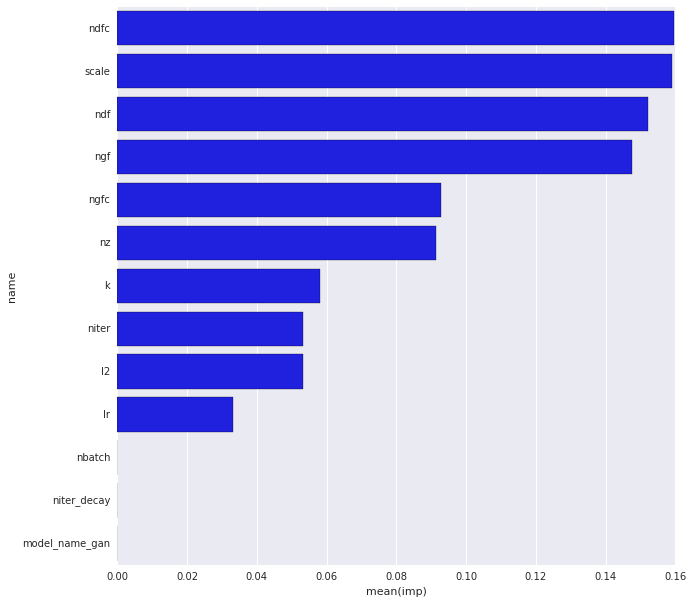

In [71]:
df = pd.DataFrame({'name': x.columns, 'imp': best_reg.feature_importances_})
df = df.sort_values(by='imp', ascending=False)
df = df.iloc[0:30]
fig = plt.figure(figsize=(10, 10))
sns.barplot(x='imp', y='name', data=df, color='blue', orient='h')
plt.show()

In [72]:
## ML insights is a package to understand supervised models
# check <https://github.com/numeristical/introspective> for more info
# e.g https://github.com/numeristical/introspective/blob/master/examples/Ames_Housing_Analysis.ipynb

In [63]:
mxr = mli.ModelXRay(best_reg, x)

In [84]:
mxr.feature_effect_summary?

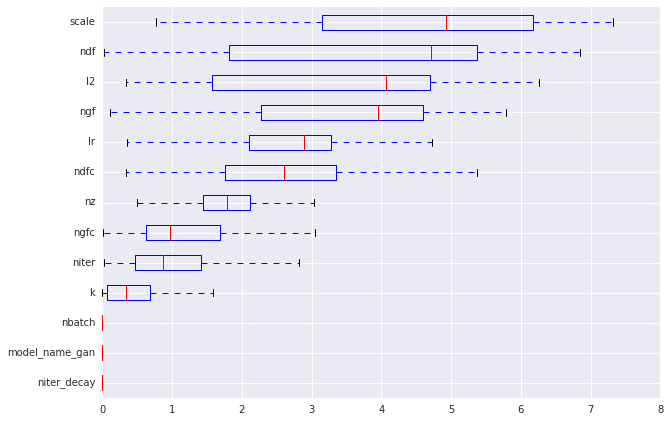

In [64]:
mxr.feature_effect_summary()

In [86]:
mxr.feature_dependence_plots?

array([135,  19, 171, 111,  38, 153, 104, 140, 152,  58])

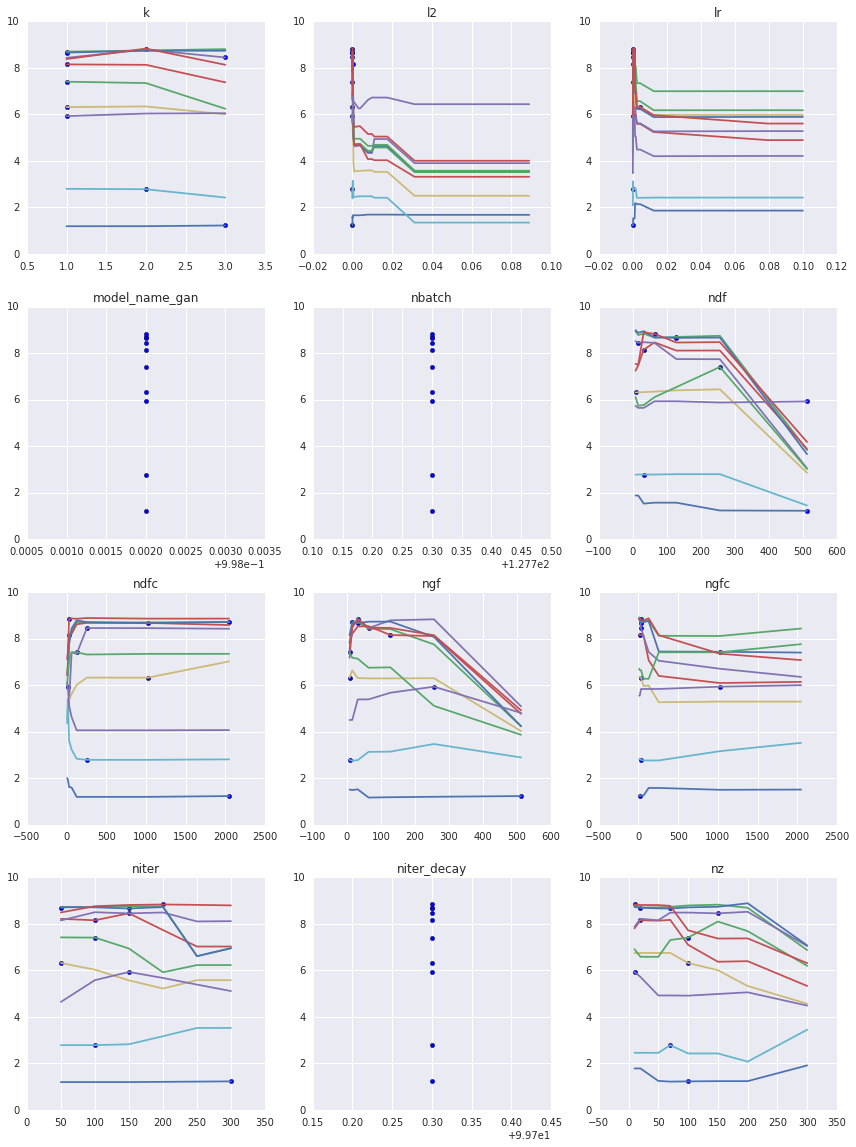

In [65]:
mxr.feature_dependence_plots(num_pts=10)